Loading images...
Performing PCA...
[[ 5.28678724e+03 -6.54727200e+03  1.49790511e+04 ...  3.04457879e-17
   5.55568379e-18  2.38592576e-18]
 [-8.37374457e+03 -1.80800534e+03 -3.02840912e+02 ...  3.04457879e-17
   5.55568379e-18  2.38592576e-18]
 [-7.08043757e+01  1.03147060e+04  4.50894875e+03 ...  3.04457879e-17
   5.55568379e-18  2.38592576e-18]
 ...
 [ 9.81433747e+03 -3.87419342e+03 -5.19205786e+03 ...  3.04457879e-17
   5.55568379e-18  2.38592576e-18]
 [-2.00066258e+03  7.12013242e+03  6.08282435e+03 ...  3.04457879e-17
   5.55568379e-18  2.38592576e-18]
 [ 4.85445821e+03 -7.52247190e+03  1.47589034e+04 ...  3.04457879e-17
   5.55568379e-18  2.38592576e-18]]
Reconstructing images using first 250 components...
Saving reconstructed images...
Extracting basis images...


/var/folders/kq/mq2cl4ps4q3f1x3d968dphr00000gp/T/ipykernel_41472/1344865913.py:76: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


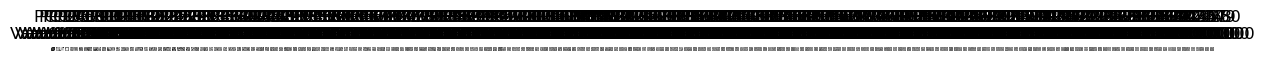

Displaying example reconstructions...


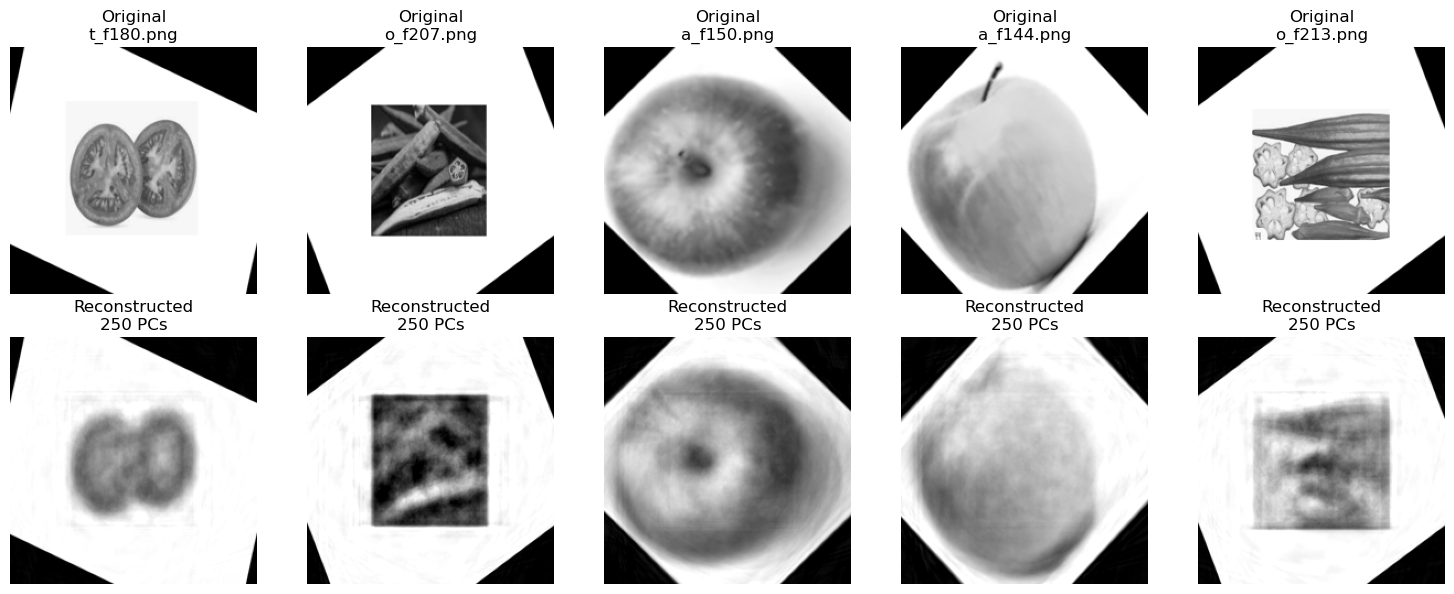

Reconstruction complete! Images saved to /Users/MaxChen/Desktop/COMP562 (CS3244)/Final Project/PCA/extract/fresh


In [13]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_images_from_folder(folder, target_size):
    """Load images from folder, resize them, and convert to grayscale"""
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to make all images same dimension
            images.append(np.array(img).flatten())  # Flatten to 1D array
            filenames.append(filename)
        except Exception as e:
            print(f"Skipping {filename}: {e}")
    return np.array(images), filenames

def reconstruct_images(pca, transformed, n_components, original_shape):
    """Reconstruct images using first n components"""
    # Use only the first n components
    transformed_truncated = transformed.copy()
    transformed_truncated[:, n_components:] = 0
    
    # Reconstruct images
    reconstructed = pca.inverse_transform(transformed_truncated)
    
    # Reshape to original image dimensions and clip values to 0-255
    reconstructed_images = []
    for img in reconstructed:
        img_reshaped = img.reshape(original_shape)
        img_reshaped = np.clip(img_reshaped, 0, 255)  # Ensure valid pixel values
        reconstructed_images.append(img_reshaped)
    
    return reconstructed_images

def extract_basis_images(pca, image_shape, n_components, output_dir):
    """
    Extract and save basis images (principal components) from PCA
    
    Args:
        pca: Fitted PCA object
        image_shape: Original image dimensions (height, width)
        n_components: Number of components to extract (None for all)
        output_dir: Directory to save basis images
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    if n_components is None:
        n_components = pca.components_.shape[0]
    
    basis_images = []
    
    plt.figure(figsize=(15, 8))
    for i in range(n_components):
        # Get the principal component (eigenvector)
        component = pca.components_[i]
        # Reshape to original image dimensions
        basis_img = component.reshape(image_shape)
        # Normalize to 0-255 range for visualization
        basis_img_normalized = ((basis_img - basis_img.min()) / 
                               (basis_img.max() - basis_img.min()) * 255)
        basis_images.append(basis_img_normalized)
        # Save as image file
        Image.fromarray(basis_img_normalized.astype('uint8')).save(
            os.path.join(output_dir, f'basis_image_pc{i+1}.png'))
        # Plot
        plt.subplot(1, n_components, i+1)
        plt.imshow(basis_img, cmap='gray')
        plt.title(f'PC {i+1}\nVar: {pca.explained_variance_ratio_[i]:.3f}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'all_basis_images.png'))
    plt.show()
    return basis_images


def save_reconstructed_images(images, filenames, output_folder, prefix='reconstructed_'):
    """Save reconstructed images to output folder"""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for img, filename in zip(images, filenames):
        output_path = os.path.join(output_folder, prefix + filename)
        Image.fromarray(img.astype('uint8')).save(output_path)

def main():
    # Configuration
    input_folder = '/Users/MaxChen/Desktop/COMP562 (CS3244)/Final Project/Scaled224/test/fresh'
    output_folder = '/Users/MaxChen/Desktop/COMP562 (CS3244)/Final Project/PCA/extract/fresh'
    target_size = (224, 224)  # Should match the size used in load_images_from_folder
    n_components_to_keep = 250  # Number of principal components to use for reconstruction
    
    # Load and preprocess images
    print("Loading images...")
    images, filenames = load_images_from_folder(input_folder, target_size)
    original_shape = target_size
    
    # Perform PCA
    print("Performing PCA...")
    pca = PCA()
    transformed = pca.fit_transform(images) #this method saves the principal components into an array
    print(transformed)
    
    # Reconstruct images using n components
    print(f"Reconstructing images using first {n_components_to_keep} components...")
    reconstructed_images = reconstruct_images(pca, transformed, n_components_to_keep, target_size)
    
    # Save reconstructed images
    print("Saving reconstructed images...")
    save_reconstructed_images(reconstructed_images, filenames, output_folder)

    # Save pcs
    print("Extracting basis images...")
    basis = extract_basis_images(pca, target_size, n_components_to_keep, output_folder)

    # Visualize some examples
    print("Displaying example reconstructions...")
    plt.figure(figsize=(15, 6))
    
    # Display original and reconstructed images
    num_examples = min(5, len(images))  # Show up to 5 examples
    for i in range(num_examples):
        # Original
        plt.subplot(2, num_examples, i+1)
        plt.imshow(images[i].reshape(original_shape), cmap='gray')
        plt.title(f"Original\n{filenames[i]}")
        plt.axis('off')
        
        # Reconstructed
        plt.subplot(2, num_examples, num_examples+i+1)
        plt.imshow(reconstructed_images[i], cmap='gray')
        plt.title(f"Reconstructed\n{n_components_to_keep} PCs")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'reconstruction_examples.png'))
    plt.show()
    
    print(f"Reconstruction complete! Images saved to {output_folder}")

if __name__ == "__main__":
    main()